In [98]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression

n_actions = 5
n_features = 20
n_data_list = [125, 250, 500, 1000, 2000, 4000, 8000]

Wx0 = np.random.normal(size=(n_actions, n_features))
Bx0 = np.random.normal(size=(n_actions, 1))

Wx = np.random.normal(size=(n_actions, n_features))
Bx = np.random.normal(size=(n_actions, 1))

Wxa_x = np.random.normal(size=(n_features,))
Wxa_a = np.random.normal(size=(n_actions,))

class Estimator():
    def __init__(self, n_data):
        self.x = np.random.normal(size=(n_data, n_features))
        self.data_generator()

    def sigmoid(self, x):
        return np.exp(np.minimum(x, 0)) / (1 + np.exp(- np.abs(x)))

    def feature2action0(self, x):
        prob_a = self.sigmoid(Wx0@x.T+Bx0).T
        prob_a = prob_a/prob_a.sum(axis=1, keepdims=True)
        prob_a[prob_a<0.1] = 0.1
        prob_a = prob_a/prob_a.sum(axis=1, keepdims=True)
        return prob_a

    def feature2action(self, x):
        prob_a = self.sigmoid(Wx@x.T+Bx).T
        prob_a = prob_a/prob_a.sum(axis=1, keepdims=True)
        return prob_a

    def sample_actions(self, prob_a):
        data_size, action_size = prob_a.shape
        actions = np.array([np.random.choice(action_size, p=prob_a[i]) for i in range(data_size)])
        result = np.zeros_like(prob_a)
        result[np.arange(data_size), actions] = 1
        return result, actions

    def action2reward(self, x, a):
        return self.sigmoid(((Wxa_x@x.T)**4-(Wxa_x@x.T)**2-(Wxa_x@x.T)+(Wxa_a@a.T)**4).T)

    def data_generator(self):
        prob_a0 = self.feature2action0(self.x)
        a0, actions0 = self.sample_actions(prob_a0)
        r0 = self.action2reward(self.x, a0)

        prob_a = self.feature2action(self.x)
        a, actions = self.sample_actions(prob_a)
        r = self.action2reward(self.x, a)

        model = LogisticRegression(multi_class='multinomial', max_iter=200, solver='lbfgs')
        model.fit(X=self.x, y=actions0)

        a_pred0 = model.predict_proba(self.x)
        a_pred0 = a_pred0 / a_pred0.sum(axis=1, keepdims=True)
    
        self.prob_a = prob_a
        self.actions0 = actions0
        self.actions = actions
        self.a_pred0 = a_pred0
        self.r0 = r0
        self.r = r
    
    def DM_estimator(self):
        r0 = self.r0
        r = self.r
        a_pred0 = self.a_pred0
        prob_a = self.prob_a

        model = LinearRegression()
        model.fit(X=np.concatenate([self.x, a_pred0], axis=1), y=r0)

        self.r_pred = model.predict(X=np.concatenate([self.x, prob_a], axis=1))

        return abs((r-self.r_pred).mean())

    def IPS_estimator(self):
        r0 = self.r0
        r = self.r
        a_pred0 = self.a_pred0
        prob_a = self.prob_a
        actions = self.actions

        self.r_pred = np.array([
            r0_elm * prob_a_elm[actions_elm] / max(a_pred0_elm[actions_elm],0.1)
        for r0_elm, prob_a_elm, actions_elm, a_pred0_elm in zip(r0, prob_a, actions, a_pred0)])

        return abs((r-self.r_pred).mean())

<Axes: xlabel='ndata'>

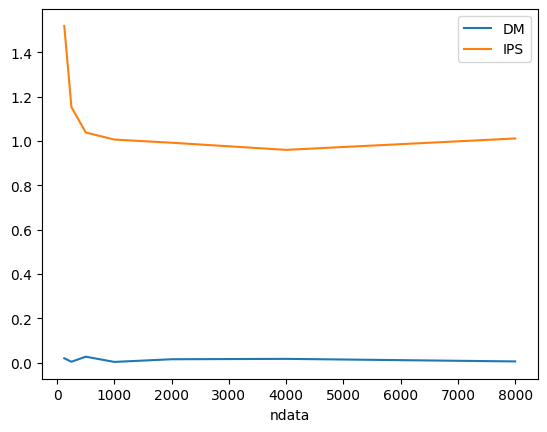

In [107]:
ress = []
for n_data in n_data_list:
    estimator = Estimator(n_data)
    ress.append(
        {
          "ndata":n_data, 
          "DM":estimator.DM_estimator(),
          "IPS":estimator.IPS_estimator()  
        }
    )
pd.DataFrame(ress).set_index("ndata").plot()